<a href="https://colab.research.google.com/github/trishaa4144/cmsc320-final/blob/rat_clean/CMSC320_Checkpt_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Researching rat sightings in New York City is crucial for addressing pressing safety and hygiene concerns that impact public health and urban living conditions. Rats are known carriers of diseases such as leptospirosis, hantavirus, and Tularemia, which can pose significant risks to human health. By analyzing data on rat sightings, we can identify hotspots where infestations are most prevalent, leading to targeted interventions and preventive measures. The chosen Rat Sightings dataset contains data points on over 250k+ rat sightings on 35+ parameters, including time, location, and neighborhoods, providing us with a rich dataset of information on rat populations in New York City.


**Main Dataset**: [Rat Sightings Dataset](https://data.cityofnewyork.us/Social-Services/Rat-Sightings/3q43-55fe/about_data)

Supplementary Datasets:
*   [Population Density](https://simplemaps.com/data/us-zips)
*   [Income dataset](https://www.kaggle.com/datasets/claygendron/us-household-income-by-zip-code-2021-2011?resource=download)



# Part 1: Initial Data Cleaning: Rat Sightings

We will start by cleaning our dataset to remove null values, and narrow our dataset down to certain columns.

First, we import our dataset.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

df = pd.read_csv("Rat_Sightings_20240917.csv", low_memory=False)

We filter out unnecessary/sparse columns like "Taxi Pick Up Location", "Bridge Highway Name", etc. This way, we cut the number of columns from 38 to 7 columns.

We are deciding to look at the following important columns: Created Date, Location Type, Incident Zip, Community Board, Borough, Latitude, Longitude.


In [2]:
# Keep only the necessary columns
df = df[['Created Date', 'Location Type', 'Incident Zip', 'Community Board', 'Borough', 'Latitude', 'Longitude']]

Next, we remove Boroughs that are "Unspecified" from the dataframe.

In [3]:
# Drop rows with unspecified boroughs
df = df[df['Borough'] != 'Unspecified']
df.reset_index(drop=True, inplace=True)

Next, drop NA values and duplicates from the dataset.

In [4]:
df.dropna(subset=['Created Date', 'Location Type', 'Incident Zip', 'Community Board', 'Borough', 'Latitude', 'Longitude'], inplace=True)

Finally, we will map Location Types to non-duplicate category classifications.

In [5]:
# Get unique values in 'Location Type'
unique_location_types = df['Location Type'].unique()

# Define mapping for residential categories
residential_mapping = {
    'Single Room Occupancy (SRO)': 'Single',
    '1-2 Family Dwelling': '1-2 Family Apartment',
    '1-2 FamilyDwelling': '1-2 Family Apartment',
    '3+ Family Apt. Building': '3+ Family',
    '3+ Family Apartment Building': '3+ Family',
    '3+ Family Apt.': '3+ Family',
    '3+Family Apt.': '3+ Family',
    '3+ Family Apt': '3+ Family',
    '1-3 Family Dwelling': '1-3 Family Dwelling',
    '1-3 Family Mixed Use Building': '1-3 Family Mixed',
    '1-2 Family Mixed Use Building': '1-2 Family Mixed',
    '3+ Family Mixed Use Building': '3+ Family Mixed',
    'Private House': 'Private House',
    'Apartment': 'Apartment',
    'Residential Property': 'Residential Property'
}

# Apply mapping to the 'Location Type' column for residential data
df['Location Type'] = df['Location Type'].replace(residential_mapping)
df

,Created Date,Location Type,Incident Zip,Community Board,Borough,Latitude,Longitude
0,5/31/2024 0:10,Vacant Lot,11377.0,02 QUEENS,QUEENS,40.740375,-73.896454
1,6/1/2024 15:01,1-2 Family Apartment,11357.0,07 QUEENS,QUEENS,40.781667,-73.807381
2,6/6/2024 10:08,3+ Family,11385.0,05 QUEENS,QUEENS,40.705669,-73.908352
3,6/25/2024 11:34,3+ Family,10467.0,07 BRONX,BRONX,40.884066,-73.879225
4,6/27/2024 10:48,1-2 Family Apartment,11220.0,07 BROOKLYN,BROOKLYN,40.642061,-74.015862
...,...,...,...,...,...,...,...
253247,5/15/2024 18:38,Vacant Lot,10011.0,04 MANHATTAN,MANHATTAN,40.740951,-74.003244
253248,5/15/2024 6:58,3+ Family,10029.0,11 MANHATTAN,MANHATTAN,40.796473,-73.936536
253249,5/15/2024 19:29,1-2 Family Apartment,11209.0,10 BROOKLYN,BROOKLYN,40.636079,-74.034564
253250,5/15/2024 10:25,3+ Family Mixed,10031.0,09 MANHATTAN,MANHATTAN,40.824874,-73.948819


Now that we have done the initial cleaning of our dataset, lets proceed forward and visualize how rat sightings compare across location, time, and income level.

First, let's visualize how rat sightings compare across Zip Codes

# Part 2: General EDA & Characteristics of Data


Next, we will continue cleaning our dataset while getting key insights on our data results.

## Main Characteristics

In [6]:
# Rough overview of features we want to consider (main characteristics of dataset)

# All boroughs and number of sightings in each
boroughs = df.groupby(['Borough']).groups.keys()
print("********** Boroughs **********")
print(list(boroughs))
mode = df.groupby(['Borough']).count()['Created Date']
print(mode)

********** Boroughs **********
['BRONX', 'BROOKLYN', 'MANHATTAN', 'QUEENS', 'STATEN ISLAND']
Borough
BRONX            45183
BROOKLYN         92179
MANHATTAN        65173
QUEENS           38457
STATEN ISLAND     9778
Name: Created Date, dtype: int64


There are 5 boroughs from which rat sightings were reported (as there are 5 boroughs in New York City). We see from the counts of sightings per each borough that Brooklyn has the highest count, 91100, and Staten Island has the fewest, 9684.

In [7]:
# All location types and number of sightings in each
location_type = df.groupby(['Location Type']).groups.keys()
print("\n********** Location Type **********")
print(list(location_type))
mode = df.groupby(['Location Type']).count()['Created Date']
print(mode)


********** Location Type **********
['1-2 Family Apartment', '1-2 Family Mixed', '1-3 Family Dwelling', '1-3 Family Mixed', '3+ Family', '3+ Family Mixed', 'Abandoned Building', 'Apartment', 'Beach', 'Building (Non-Residential)', 'Cafeteria - Public School', 'Catch Basin/Sewer', 'Catering Service', 'Commercial Building', 'Commercial Property', 'Construction Site', 'Day Care/Nursery', 'Government Building', 'Grocery Store', 'Ground', 'Hospital', 'Office Building', 'Other', 'Other (Explain Below)', 'Parking Lot/Garage', 'Private House', 'Public Garden', 'Public Stairs', 'Residence', 'Residential Building', 'Residential Property', 'Restaurant', 'Restaurant/Bar/Deli/Bakery', 'Retail Store', 'School', 'School/Pre-School', 'Single', 'Store', 'Street Area', 'Street Fair Vendor', 'Summer Camp', 'Vacant Building', 'Vacant Lot', 'Vacant Lot/Property']
Location Type
1-2 Family Apartment           47176
1-2 Family Mixed                4124
1-3 Family Dwelling               15
1-3 Family Mixed    

There are 44 types of locations in the reported rat sightings, ranging from 1 to 104476 sightings in a location type. The location types with only 1 sighting are potential outliers--this includes Public School Cafeteria, Catering Service, Private House, Retail Store, and Street Fair Vendor. From these categories, it's possible that there is bias influencing the low count of reported sightings. For instance, people may feel less inclined to report a rat sighting at a private event or venue.

In [8]:
# All zip codes and number of sightings in each (in descending order)
zip_codes = df.groupby(['Incident Zip']).groups.keys()
print("\n********** Incident Zip Code **********")
print(list(zip_codes))
# print top 10 counts per zip codes
zip_code_dict = {}
for key in zip_codes:
  zip_code_dict[key] = len(df[df['Incident Zip'] == key])
print("\n(Incident Zip Code , Count) in descending order:")
zip_code_dict = sorted(zip_code_dict.items(), key=lambda item: item[1], reverse=True)
print(zip_code_dict)


********** Incident Zip Code **********
[83.0, 10000.0, 10001.0, 10002.0, 10003.0, 10004.0, 10005.0, 10006.0, 10007.0, 10009.0, 10010.0, 10011.0, 10012.0, 10013.0, 10014.0, 10016.0, 10017.0, 10018.0, 10019.0, 10020.0, 10021.0, 10022.0, 10023.0, 10024.0, 10025.0, 10026.0, 10027.0, 10028.0, 10029.0, 10030.0, 10031.0, 10032.0, 10033.0, 10034.0, 10035.0, 10036.0, 10037.0, 10038.0, 10039.0, 10040.0, 10041.0, 10044.0, 10045.0, 10048.0, 10065.0, 10069.0, 10075.0, 10111.0, 10112.0, 10115.0, 10118.0, 10119.0, 10120.0, 10121.0, 10128.0, 10151.0, 10162.0, 10174.0, 10178.0, 10271.0, 10278.0, 10280.0, 10282.0, 10301.0, 10302.0, 10303.0, 10304.0, 10305.0, 10306.0, 10307.0, 10308.0, 10309.0, 10310.0, 10312.0, 10314.0, 10451.0, 10452.0, 10453.0, 10454.0, 10455.0, 10456.0, 10457.0, 10458.0, 10459.0, 10460.0, 10461.0, 10462.0, 10463.0, 10464.0, 10465.0, 10466.0, 10467.0, 10468.0, 10469.0, 10470.0, 10471.0, 10472.0, 10473.0, 10474.0, 10475.0, 11001.0, 11004.0, 11040.0, 11101.0, 11102.0, 11103.0, 11104.0

Considering the number of sightings per zip code, we can observe that the zip code with the greatest number of sightings is in Brooklyn, which is the borough with the greatest number of sightings. Aside from the zip code with the second-highest number of sightings belonging to Manhattan, the other zip codes in the top 5 all belong to Brooklyn.

In [9]:
# Rows, columns
print("\n(Rows, columns):")
print(df.shape)


(Rows, columns):
(250770, 7)


## Visualizing Residential & Non-Residential Rat Sightings Data

Let's next observe the relationship between rat sightings in residential and non-residential areas. From this visualization, we can see that the proportion of residential rat sightings is much higher than non-residential sightings. This provides us with insight into the makeup of our dataset.

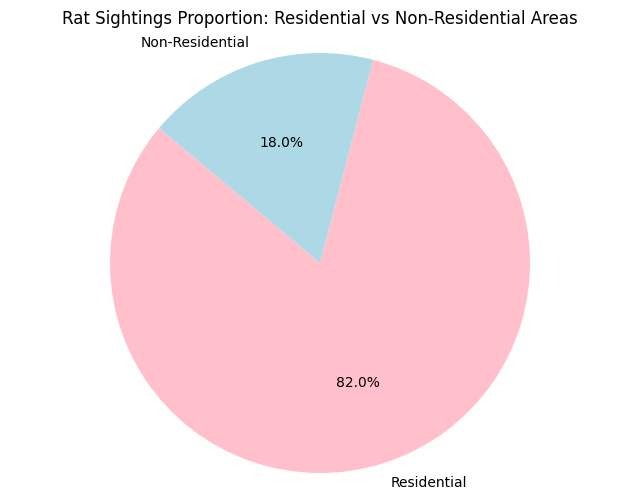

In [10]:
# Create the residential and non-residential DataFrames
residential_df = df[df['Location Type'].isin(residential_mapping.values())]
nonresidential_df = df[~df['Location Type'].isin(residential_mapping.values())]
nonresidential_df = nonresidential_df[~nonresidential_df['Location Type'].isin(['Other', 'Other (Explain Below)'])]

# Basic Data Exploration - residential vs nonresidential pie chart
residential_count = residential_df.shape[0]
nonresidential_count = nonresidential_df.shape[0]

# Data for the pie chart
labels = ['Residential', 'Non-Residential']
sizes = [residential_count, nonresidential_count]
colors = ['pink', 'lightblue']

# Pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Rat Sightings Proportion: Residential vs Non-Residential Areas')
# Equal aspect ratio ensures that pie chart is drawn as a circle.
plt.axis('equal')
plt.show()

Next, let's take a look at the geographic density of rat sightings using our Latitude and Longitude data along with frequencies. It can be seen from the map that there are high concentrations of rat sightings located within Manhattan and Brooklyn in particular.

## Visualizing Location of Rat Sightings

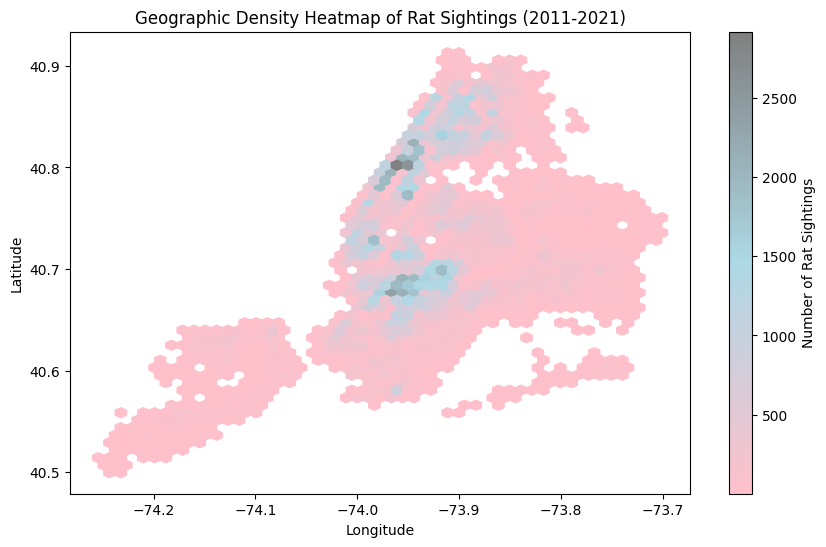

In [11]:
import matplotlib.colors as mcolors

cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ["pink", "lightblue", "grey"])
plt.figure(figsize=(10, 6))
plt.hexbin(df['Longitude'], df['Latitude'], gridsize=50, cmap=cmap, mincnt=1)
plt.colorbar(label='Number of Rat Sightings')
plt.title('Geographic Density Heatmap of Rat Sightings (2011-2021)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


# Part 3: Rat Sightings over Time & Seasons

In this section, we explore the patterns of rat sightings over time  by extracting relevant date information from our dataset and visualizing these trends. We will focus on how rat sightings vary across different months and perform a statistical comparison between seasons—specifically, winter and summer.


Extract the month, week, and day from the dates in the dataset.

In [12]:
# Convert 'Created Date' to datetime format
df['Created Date'] = pd.to_datetime(df['Created Date'])

# Extract month, week, and day information
df['Month'] = df['Created Date'].dt.month
df['Week'] = df['Created Date'].dt.isocalendar().week
df['Day'] = df['Created Date'].dt.day

# Check the updated dataframe
print(df[['Created Date', 'Month', 'Week', 'Day']].head())

         Created Date  Month  Week  Day
0 2024-05-31 00:10:00      5    22   31
1 2024-06-01 15:01:00      6    22    1
2 2024-06-06 10:08:00      6    23    6
3 2024-06-25 11:34:00      6    26   25
4 2024-06-27 10:48:00      6    26   27


## Visualizing Rat sightings over Months

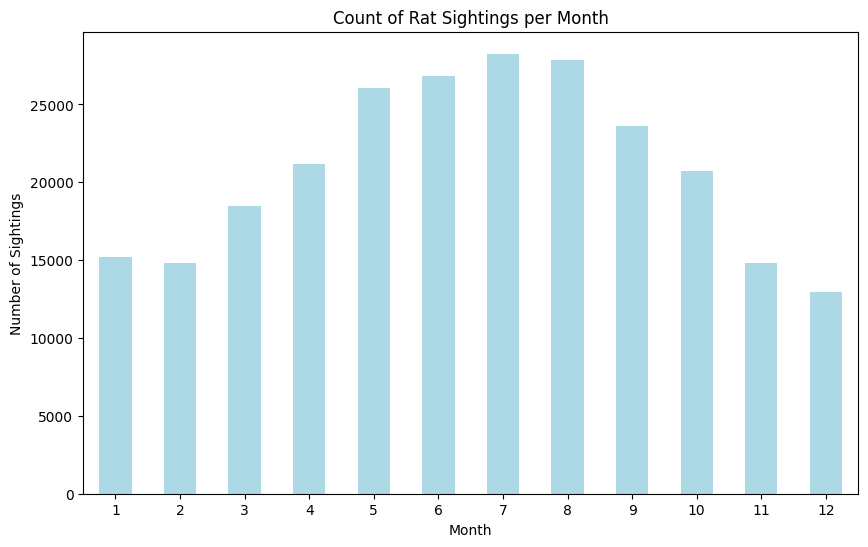

In [13]:
# Count rat sightings per month
rat_sightings_by_month = df['Month'].value_counts().sort_index()

# Plot the results
plt.figure(figsize=(10, 6))
rat_sightings_by_month.plot(kind='bar', color='lightblue')
plt.title('Count of Rat Sightings per Month')
plt.xlabel('Month')
plt.ylabel('Number of Sightings')
plt.xticks(rotation=0)
plt.show()

## Visualizing Rat Sightings over Months & Years

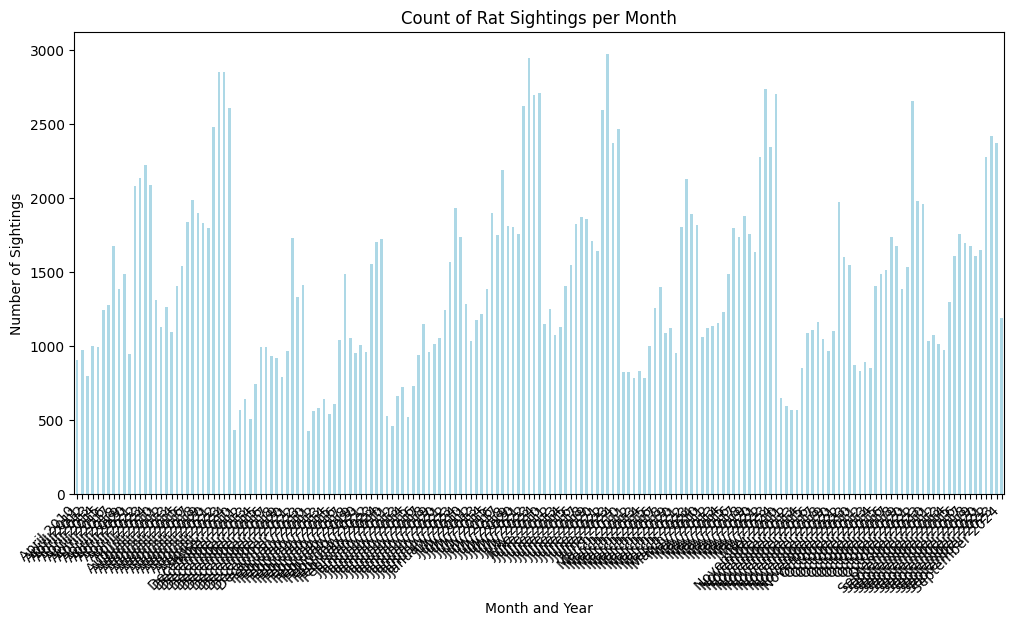

In [14]:
df['Year-Month'] = df['Created Date'].dt.strftime('%B %Y')
rat_sightings_by_month = df['Year-Month'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
rat_sightings_by_month.plot(kind='bar', color='lightblue')
plt.title('Count of Rat Sightings per Month')
plt.xlabel('Month and Year')
plt.ylabel('Number of Sightings')
plt.xticks(rotation=45, ha='right')  # Rotate x labels for better readability
plt.show()

Next, we will cut this up into quantiles and identify Low/Medium/High value for rat sighting.

In [15]:
quantiles = pd.qcut(rat_sightings_by_month, 3, labels=["Low", "Medium", "High"])

rat_sightings_by_month_category = quantiles

category_mapping = rat_sightings_by_month_category.to_dict()

df['Category'] = df['Year-Month'].map(category_mapping)
df

,Created Date,Location Type,Incident Zip,Community Board,Borough,Latitude,Longitude,Month,Week,Day,Year-Month,Category
0,2024-05-31 00:10:00,Vacant Lot,11377.0,02 QUEENS,QUEENS,40.740375,-73.896454,5,22,31,May 2024,High
1,2024-06-01 15:01:00,1-2 Family Apartment,11357.0,07 QUEENS,QUEENS,40.781667,-73.807381,6,22,1,June 2024,High
2,2024-06-06 10:08:00,3+ Family,11385.0,05 QUEENS,QUEENS,40.705669,-73.908352,6,23,6,June 2024,High
3,2024-06-25 11:34:00,3+ Family,10467.0,07 BRONX,BRONX,40.884066,-73.879225,6,26,25,June 2024,High
4,2024-06-27 10:48:00,1-2 Family Apartment,11220.0,07 BROOKLYN,BROOKLYN,40.642061,-74.015862,6,26,27,June 2024,High
...,...,...,...,...,...,...,...,...,...,...,...,...
253247,2024-05-15 18:38:00,Vacant Lot,10011.0,04 MANHATTAN,MANHATTAN,40.740951,-74.003244,5,20,15,May 2024,High
253248,2024-05-15 06:58:00,3+ Family,10029.0,11 MANHATTAN,MANHATTAN,40.796473,-73.936536,5,20,15,May 2024,High
253249,2024-05-15 19:29:00,1-2 Family Apartment,11209.0,10 BROOKLYN,BROOKLYN,40.636079,-74.034564,5,20,15,May 2024,High
253250,2024-05-15 10:25:00,3+ Family Mixed,10031.0,09 MANHATTAN,MANHATTAN,40.824874,-73.948819,5,20,15,May 2024,High


## **TEST 1:** T-test on Summer vs Winter Rat Sightings


H0: There is no significant difference in rat sightings between winter months and summer months.

H1: There is a significant difference in rat sightings between winter months and summer months.

In [16]:
# Example: Compare rat sightings between Winter (Dec-Feb) and Summer (Jun-Aug)
winter_months = [12, 1, 2]
summer_months = [6, 7, 8]

# Get sightings for winter and summer
winter_sightings = df[df['Month'].isin(winter_months)]['Month'].count()
summer_sightings = df[df['Month'].isin(summer_months)]['Month'].count()

# Filter the data for winter and summer months
winter_data = df[df['Month'].isin([12, 1, 2])]
summer_data = df[df['Month'].isin([6, 7, 8])]


In [17]:
# Check the length of data for both groups
print("Winter sightings count:", len(winter_data))
print("Summer sightings count:", len(summer_data))

Winter sightings count: 42933
Summer sightings count: 82968


In [18]:
# Check for NaN values in these groups
print("NaN in winter data:", winter_data.isna().sum())
print("NaN in summer data:", summer_data.isna().sum())

# Drop rows with missing values in 'Incident Zip', 'Latitude', or 'Longitude'
winter_data_clean = winter_data.dropna(subset=['Incident Zip', 'Latitude', 'Longitude'])
summer_data_clean = summer_data.dropna(subset=['Incident Zip', 'Latitude', 'Longitude'])

# Check cleaned data
print("Cleaned winter data count:", len(winter_data_clean))
print("Cleaned summer data count:", len(summer_data_clean))

NaN in winter data: Created Date       0
Location Type      0
Incident Zip       0
Community Board    0
Borough            0
Latitude           0
Longitude          0
Month              0
Week               0
Day                0
Year-Month         0
Category           0
dtype: int64
NaN in summer data: Created Date       0
Location Type      0
Incident Zip       0
Community Board    0
Borough            0
Latitude           0
Longitude          0
Month              0
Week               0
Day                0
Year-Month         0
Category           0
dtype: int64
Cleaned winter data count: 42933
Cleaned summer data count: 82968


T test: T-test is only valid if the sample size is normally distributed and independent. By the Central Limit theorem, since the sizes of both datasets are over 30, a normal distribution can be assumed.

In [19]:
# Count the number of sightings per day in both seasons
winter_sightings_per_day = winter_data_clean['Created Date'].dt.date.value_counts()
summer_sightings_per_day = summer_data_clean['Created Date'].dt.date.value_counts()

# Perform the t-test comparing the number of sightings per day in winter vs summer
t_stat, p_value = stats.ttest_ind(winter_sightings_per_day, summer_sightings_per_day, equal_var=False)

print(f'T-statistic: {t_stat}, P-value: {p_value}')

T-statistic: -32.5198022279798, P-value: 2.2052905701576025e-193


The T-test results in a p-value of approximately 1.70e-191. Thus, we reject our null hypothesis of no significant difference between Summer and Winter months. This extremely low p-value indicates a highly significant difference in the number of rat sightings between winter and summer. This supports the conclusion that rat sightings are substantially more prevalent during the summer months compared to winter. The results highlight the importance of seasonal factors in understanding rat populations and could inform pest management strategies.


**Insights: Correlation 1** - In examining the dataset of rat sightings, it becomes evident that there is a noticeable correlation between the number of rat sightings and the seasons, particularly when comparing warmer months to colder months. The data and graph indicates that rat sightings tend to increase significantly during the warmer months of summer (June, July, and August). This trend can be attributed to several factors, including increased outdoor activity, which leads to more people being in public spaces and consequently more reports of rat sightings. Additionally, the summer months typically provide a greater abundance of food sources for rats, whether through discarded food in parks and streets or increased human activity in residential areas. Conversely, there is a decline in rat sightings during the winter months (December, January, and February), which can be explained by harsh weather conditions that limit rat activity and their ability to forage for food. Moreover, rats may seek shelter in warmer environments during the winter, such as basements or other protected areas, making them less visible or accessible to the public.


# Part 4: Rat Sightings and Location

## **Test 2**: ANOVA Test on Rat Sightings across Boroughs

The ANOVA test is used to assess if there are significant differences in average rat sightings per zip code across different boroughs. Its purpose is to compare the means of multiple groups.

H0: There are no significant differences in mean rat sightings across boroughs

H1: There are significant differences in mean rat sightings across boroughs

In [20]:
from scipy import stats

sightings_per_zip = df.groupby(['Borough', 'Incident Zip']).size().reset_index(name='Sightings')

# group by Borough to prepare for ANOVA
sightings_by_borough = sightings_per_zip.groupby('Borough')['Sightings'].apply(list).reset_index()
print(sightings_by_borough)

# Extracting sightings lists for each borough
borough_groups = sightings_by_borough['Sightings'].tolist()

# Perform ANOVA
f_statistic, p_value = stats.f_oneway(*borough_groups)

print(f'P-value: {p_value}')

         Borough                                          Sightings
0          BRONX  [1797, 2525, 2655, 1300, 1848, 3660, 3131, 322...
1       BROOKLYN  [1996, 2260, 739, 2730, 3726, 3810, 2329, 1473...
2      MANHATTAN  [26, 8, 919, 2493, 1711, 103, 107, 165, 416, 2...
3         QUEENS  [91, 66, 17, 1401, 797, 1199, 777, 1239, 872, ...
4  STATEN ISLAND  [1031, 592, 642, 825, 900, 1208, 181, 591, 420...
P-value: 1.6924366973020327e-09


We Reject the null hypothesis (H0) because the p-value of 1.685e-9 is far less than the alpha value of 0.05. This indicates that there are significant difference in rat sightings across boroughs. However, a post-hoc test is necessary to identify which boroughs have more significant differences. For this, we use Turkey HSD post-hoc test to identify significant differences.

But first, let's visualize the results of the ANOVA Test.

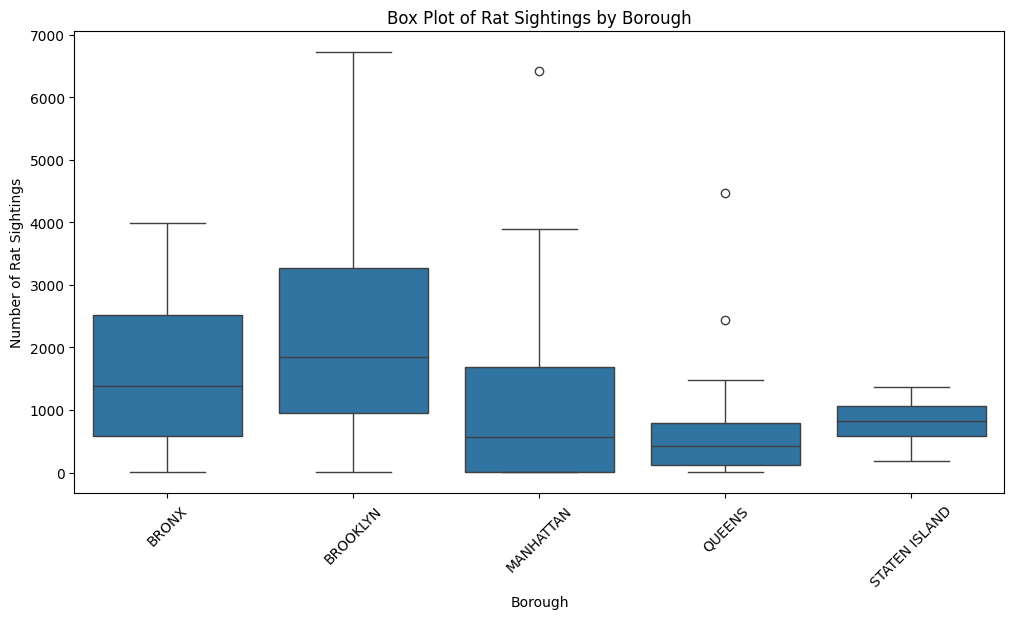

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(x='Borough', y='Sightings', data=sightings_per_zip)
plt.title('Box Plot of Rat Sightings by Borough')
plt.xlabel('Borough')
plt.ylabel('Number of Rat Sightings')
plt.xticks(rotation=45)
plt.show()


## **Follow-up** Post-hoc Test with Turkey's HSD Test



In [22]:
import matplotlib.pyplot as plt
from statsmodels.stats.multicomp import pairwise_tukeyhsd

long_df = sightings_per_zip[['Borough', 'Sightings']].copy()
long_df = long_df.explode('Sightings').reset_index(drop=True)
long_df['Sightings'] = pd.to_numeric(long_df['Sightings'], errors='coerce')

# Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(long_df['Sightings'], long_df['Borough'], alpha=0.05)
print(tukey_results)


         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
  group1      group2     meandiff  p-adj    lower      upper   reject
---------------------------------------------------------------------
    BRONX      BROOKLYN   636.7036  0.184  -159.8551 1433.2623  False
    BRONX     MANHATTAN  -570.5648 0.2089 -1305.5915  164.4619  False
    BRONX        QUEENS  -975.3527  0.003 -1710.3793  -240.326   True
    BRONX STATEN ISLAND  -743.2011 0.3729 -1875.6395  389.2372  False
 BROOKLYN     MANHATTAN -1207.2684    0.0 -1858.4881 -556.0487   True
 BROOKLYN        QUEENS -1612.0563    0.0  -2263.276 -960.8366   True
 BROOKLYN STATEN ISLAND -1379.9048 0.0048 -2459.8305 -299.9791   True
MANHATTAN        QUEENS  -404.7879 0.2999  -979.1097  169.5339  False
MANHATTAN STATEN ISLAND  -172.6364 0.9908 -1208.0097   862.737  False
   QUEENS STATEN ISLAND   232.1515 0.9723  -803.2218 1267.5248  False
---------------------------------------------------------------------


The results suggest that Brooklyn has significantly lower rat sightings compared to boroughs such as Manhattan, Queens, and Staten Island.

The results do not suggest significant differences in sightings between Bronx and Brooklyn, or between some other borough pairs.


One consideration to make is the size  of respective regions when interpreting these results. It would be important to incorporate this data to determine concentration of rat sightings when performing analysis within our final findings.

# Part 5: Rat Sightings in Residential vs. Non-Residential Properties

## **Test 3:** Mann-Whitney Test on Residential vs. Non-Residential Rat Sightings

In [23]:
from scipy.stats import mannwhitneyu

residential_sightings = residential_df['Incident Zip'].value_counts()
non_residential_sightings = nonresidential_df['Incident Zip'].value_counts()

# Mann-Whitney U Test
u_stat, p_value = mannwhitneyu(residential_sightings, non_residential_sightings, alternative='two-sided')

# Output results
print(f'Mann-Whitney U Statistic: {u_stat}, P-value: {p_value}')

Mann-Whitney U Statistic: 29047.0, P-value: 5.084196762032582e-22


As the p-value of 5.245e-22 is less than the significance level, alpha = 0.05, we reject the Null Hypothesis (H₀) that the distribution of rat sightings in residential areas is equal to that in non-residential areas. This proves that we have statistically significant evidence to conclude in favor of the alternative hypothesis that the distribution of rat sightings in residential areas is not equal to that in non-residential areas.

### Visualization

We can also visualize the results from the Mann-Whitney Test using a bar graph:

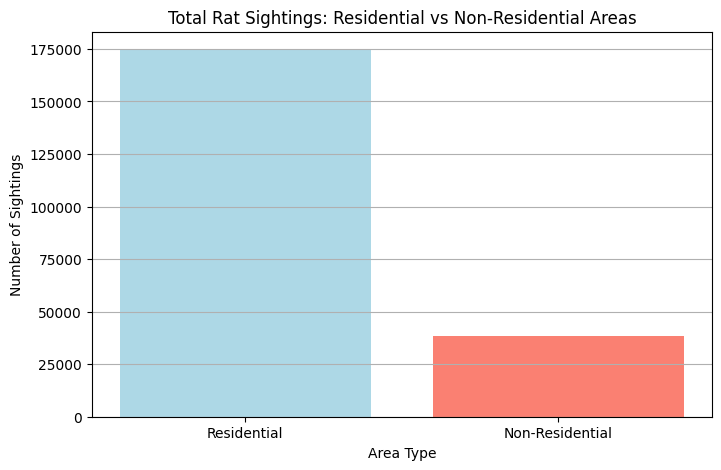

In [24]:
# Visualization
counts = pd.DataFrame({
    'Area Type': ['Residential', 'Non-Residential'],
    'Sightings': [residential_sightings.sum(), non_residential_sightings.sum()]
})

plt.figure(figsize=(8, 5))
plt.bar(counts['Area Type'], counts['Sightings'], color=['lightblue', 'salmon'])
plt.title('Total Rat Sightings: Residential vs Non-Residential Areas')
plt.xlabel('Area Type')
plt.ylabel('Number of Sightings')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

# Income Data Cleaning & Merging Datasets (NEW nov 29)

In [25]:
import pandas as pd

# Income data df, zipcodes for NYC boroughs, and rat sightings df
income_df = pd.read_csv("us_income_zipcode.csv")
zipcode_borough = pd.read_csv("New_York_State_ZIP_Codes-County_FIPS_Cross-Reference.csv")
# df = pd.read_csv("Rat_Sightings_20240917.csv", low_memory=False)

### Dropping all margin of error columns
def drop_margin_cols():
    lst = income_df.columns
    remove_list = []

    for col in lst:
        if "Margin of Error" in col:
            remove_list.append(col)
    return remove_list

lst = drop_margin_cols()
income_df.drop(lst, axis=1, inplace=True)

#Dropping other useless columns
income_df.drop(["Geography", "Geographic Area Name"], axis=1, inplace=True)
#income_df

In [26]:
#Dropping columns we don't need from borough df
zipcode_borough.drop(["State FIPS", "County Code", "File Date", "County FIPS"], axis=1, inplace=True)

In [27]:
#Merging income_df and zipcode_borough
merged_df = income_df.merge(zipcode_borough, left_on="ZIP", right_on="ZIP Code")

#Filtering to only the 5 boroughs of NYC
merged_df = merged_df[(merged_df["County Name"] == "Bronx") | (merged_df["County Name"] == "Queens") | (merged_df["County Name"] == "New York") | (merged_df["County Name"] == "Kings") | (merged_df["County Name"] == "Richmond")]

#Dropping ZIP Code cause we don't need it (redundant column)
merged_df.drop("ZIP Code", axis=1, inplace=True)

#Fixing year to make it an int
merged_df["Year"] = merged_df["Year"].astype(int)

#Fixing households to make them ints
merged_df["Households"] = merged_df["Households"].astype(int)

#No more NA values!!!
merged_df.dropna(inplace=True)
# merged_df

In [28]:
#Merging invome with the rat sightings data
final_df = merged_df.merge(df, left_on="ZIP", right_on="Incident Zip")

# A function to keep only the important columns and mean/median income columns for final dataframe
def save_cols():
    columns = final_df.columns
    save_lst = []
    important = ["ZIP", "Households", "Year", "Created Date", "Location Type", "Community Board", "Borough", "Latitude", "Longitude"]

    for col in columns:
        if "Mean Income (Dollars)" in col or "Median Income (Dollars)" in col:
            save_lst.append(col)
        elif col in important:
            save_lst.append(col)

    return save_lst

lst = save_cols()
final_df = final_df[lst]

In [29]:
# Double check that we dont have NA values
final_df.dropna(inplace=True)
# final_df.isna().sum()

In [30]:
# Final income-rat sightings dataframe
final_df

,ZIP,Households,Households Median Income (Dollars),Households Mean Income (Dollars),Families Median Income (Dollars),Families Mean Income (Dollars),Married-Couple Families Median Income (Dollars),Married-Couple Families Mean Income (Dollars),Nonfamily Households Median Income (Dollars),Nonfamily Households Mean Income (Dollars),Year,Created Date,Location Type,Community Board,Borough,Latitude,Longitude
0,10002,34737,37093.0,76115.0,38815.0,82382.0,51689.0,101513.0,32489.0,69003.0,2021,2024-05-16 11:19:00,3+ Family,03 MANHATTAN,MANHATTAN,40.712894,-73.996101
1,10002,34737,37093.0,76115.0,38815.0,82382.0,51689.0,101513.0,32489.0,69003.0,2021,2024-08-31 20:15:00,Commercial Building,03 MANHATTAN,MANHATTAN,40.712995,-73.988529
2,10002,34737,37093.0,76115.0,38815.0,82382.0,51689.0,101513.0,32489.0,69003.0,2021,2024-08-15 05:24:00,3+ Family,03 MANHATTAN,MANHATTAN,40.712353,-73.993947
3,10002,34737,37093.0,76115.0,38815.0,82382.0,51689.0,101513.0,32489.0,69003.0,2021,2024-06-04 20:19:00,Office Building,03 MANHATTAN,MANHATTAN,40.722009,-73.993376
4,10002,34737,37093.0,76115.0,38815.0,82382.0,51689.0,101513.0,32489.0,69003.0,2021,2024-05-08 17:31:00,3+ Family,03 MANHATTAN,MANHATTAN,40.716111,-73.992998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
977197,11435,17950,54086.0,65131.0,57789.0,70488.0,67135.0,78335.0,39375.0,51434.0,2011,2024-04-26 17:54:00,1-2 Family Apartment,08 QUEENS,QUEENS,40.711187,-73.810153
977198,11435,17950,54086.0,65131.0,57789.0,70488.0,67135.0,78335.0,39375.0,51434.0,2011,2024-05-01 13:05:00,1-2 Family Apartment,12 QUEENS,QUEENS,40.687113,-73.799311
977199,11435,17950,54086.0,65131.0,57789.0,70488.0,67135.0,78335.0,39375.0,51434.0,2011,2024-05-02 20:37:00,Commercial Building,12 QUEENS,QUEENS,40.701386,-73.804111
977200,11435,17950,54086.0,65131.0,57789.0,70488.0,67135.0,78335.0,39375.0,51434.0,2011,2024-05-04 18:17:00,1-2 Family Apartment,12 QUEENS,QUEENS,40.694572,-73.809710


# Part 6 (Appendix): Analyzing Income - Cleaning & Visualizing Income in New York


We also cleaned a dataset on income differences in New York across Boroughs. Merging this dataset with our rat sightings dataset will be useful to provide insights into rat sighting relationships with income levels across New York.

Loading in the US Census data for income per zipcode and the zipcode to borough CSVs:

In [31]:
income_df = pd.read_csv("us_income_zipcode.csv")
zipcode_borough = pd.read_csv("New_York_State_ZIP_Codes-County_FIPS_Cross-Reference.csv")

Now, we will clean the income and borough dataframes so that we can merge them together. First, we will drop all of the Margin of Error columns, as this data is not useful for our purposes. We are also dropping Geography, Geographic Area Name, State FIPS, County Code, File Date, and County FIPS as well for the same reasons. Afterwards, we merge the borough and income datasets on ZIP code. During this merge, we come to realize that Married-Couple Families Mean Income (Dollars) has a large number of NAN values (905), so we are choosing to not work with this column. After making Households and year into ints, we will use the dropna() function to drop our NA values.

In [32]:
### Dropping all margin of error columns
def drop_margin_cols():
    lst = income_df.columns
    remove_list = []

    for col in lst:
        if "Margin of Error" in col:
            remove_list.append(col)
    return remove_list

lst = drop_margin_cols()
income_df.drop(lst, axis=1, inplace=True)

#Dropping columns we don't need from income_df
income_df.drop(["Geography", "Geographic Area Name"], axis=1, inplace=True)

#Dropping columns we don't need from borough df
zipcode_borough.drop(["State FIPS", "County Code", "File Date", "County FIPS"], axis=1, inplace=True)

#merging the dataframes together
merged_df = income_df.merge(zipcode_borough, left_on="ZIP", right_on="ZIP Code")

#Filtering to only the counties that we want to look at (NYC Area)
merged_df = merged_df[(merged_df["County Name"] == "Bronx") | (merged_df["County Name"] == "Queens") | (merged_df["County Name"] == "New York") | (merged_df["County Name"] == "Kings") | (merged_df["County Name"] == "Richmond")]

#Dropping this Mean Income because of the number of NaN values we found (905)
#Dropping ZIP Code cause we don't need it
merged_df.drop(["Married-Couple Families Mean Income (Dollars)", "ZIP Code"], axis=1, inplace=True)

#Fixing year to make it an int
merged_df["Year"] = merged_df["Year"].astype(int)

#Fixing households to make them ints
merged_df["Households"] = merged_df["Households"].astype(int)

#No more NA values!!!
merged_df.dropna()

,ZIP,Households,"Households Less Than $10,000","Households $10,000 to $14,999","Households $15,000 to $24,999","Households $25,000 to $34,999","Households $35,000 to $49,999","Households $50,000 to $74,999","Households $75,000 to $99,999","Households $100,000 to $149,999",...,"Nonfamily Households $50,000 to $74,999","Nonfamily Households $75,000 to $99,999","Nonfamily Households $100,000 to $149,999","Nonfamily Households $150,000 to $199,999","Nonfamily Households $200,000 or More",Nonfamily Households Median Income (Dollars),Nonfamily Households Mean Income (Dollars),Nonfamily Households Nonfamily Income in the Past 12 Months,Year,County Name
1,10001,14273,7.2,3.4,5.4,3.3,7.4,11.5,11.2,14.9,...,12.2,13.0,15.7,11.4,19.0,89723.0,131592.0,20.1,2021,New York
2,10002,34737,13.0,11.8,12.9,10.0,9.1,11.2,9.2,9.2,...,10.0,9.4,10.1,4.3,8.0,32489.0,69003.0,34.8,2021,New York
3,10003,25181,6.8,2.2,3.3,4.3,4.2,11.9,6.9,13.3,...,14.7,7.6,14.2,10.7,27.7,105808.0,175535.0,28.5,2021,New York
4,10004,2113,2.2,0.0,0.9,1.6,0.4,2.0,6.1,13.5,...,3.1,10.6,19.9,21.0,38.7,159518.0,218597.0,25.7,2021,New York
5,10005,4782,0.9,0.0,0.1,1.4,2.1,9.2,6.1,15.2,...,11.7,5.0,17.2,18.4,41.4,185125.0,198121.0,21.7,2021,New York
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22134,11692,5830,14.6,8.0,9.2,16.0,11.7,17.1,8.5,10.3,...,14.9,7.9,5.3,0.3,1.2,25617.0,39178.0,40.4,2011,Queens
22135,11693,4583,12.3,4.6,7.6,7.8,17.6,16.1,14.8,15.4,...,16.3,10.2,5.9,1.6,2.6,40742.0,57435.0,46.1,2011,Kings
22136,11693,4583,12.3,4.6,7.6,7.8,17.6,16.1,14.8,15.4,...,16.3,10.2,5.9,1.6,2.6,40742.0,57435.0,46.1,2011,Queens
22137,11694,8135,4.9,4.2,8.1,10.3,9.3,14.3,11.6,20.3,...,16.4,10.9,11.4,0.4,1.7,37194.0,52125.0,47.7,2011,Queens


Now we will merge this dataframe with our rat sightings dataframe. Rename Incident Zip to ZIP and convert the values to ints. Then merge the dataframes on ZIP. Drop na values and begin working on a chi-squared test.

In [33]:
#Making changes to df to merge well
df["Incident Zip"] = df["Incident Zip"].astype(int)
df.rename(columns={'Incident Zip': 'ZIP'}, inplace=True)

#Merging
merged_df.dropna()
rat_income = df.merge(merged_df, on="ZIP", how="inner")

#Getting rid of na values in the median income cols
rat_income.dropna()
rat_income.dropna(subset=["Families Median Income (Dollars)", "Married-Couple Families Median Income (Dollars)"])

,Created Date,Location Type,ZIP,Community Board,Borough,Latitude,Longitude,Month,Week,Day,...,"Nonfamily Households $50,000 to $74,999","Nonfamily Households $75,000 to $99,999","Nonfamily Households $100,000 to $149,999","Nonfamily Households $150,000 to $199,999","Nonfamily Households $200,000 or More",Nonfamily Households Median Income (Dollars),Nonfamily Households Mean Income (Dollars),Nonfamily Households Nonfamily Income in the Past 12 Months,Year,County Name
0,2024-05-31 00:10:00,Vacant Lot,11377,02 QUEENS,QUEENS,40.740375,-73.896454,5,22,31,...,18.3,14.0,10.0,3.9,3.0,48655.0,61845.0,30.3,2021,Queens
1,2024-05-31 00:10:00,Vacant Lot,11377,02 QUEENS,QUEENS,40.740375,-73.896454,5,22,31,...,17.1,10.8,9.7,3.7,2.3,44283.0,59071.0,34.5,2020,Queens
2,2024-05-31 00:10:00,Vacant Lot,11377,02 QUEENS,QUEENS,40.740375,-73.896454,5,22,31,...,18.6,10.2,10.4,3.8,2.7,45984.0,61366.0,38.1,2019,Queens
3,2024-05-31 00:10:00,Vacant Lot,11377,02 QUEENS,QUEENS,40.740375,-73.896454,5,22,31,...,20.5,8.9,9.3,3.8,1.8,43911.0,56980.0,35.7,2018,Queens
4,2024-05-31 00:10:00,Vacant Lot,11377,02 QUEENS,QUEENS,40.740375,-73.896454,5,22,31,...,21.3,9.1,8.6,3.7,1.6,43851.0,56124.0,36.5,2017,Queens
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2791937,2024-05-15 20:11:00,3+ Family,11106,01 QUEENS,QUEENS,40.759002,-73.926703,5,20,15,...,19.2,13.0,13.0,3.5,1.6,50390.0,62195.0,31.9,2015,Queens
2791938,2024-05-15 20:11:00,3+ Family,11106,01 QUEENS,QUEENS,40.759002,-73.926703,5,20,15,...,18.8,13.6,12.0,3.2,2.1,49381.0,62600.0,29.8,2014,Queens
2791939,2024-05-15 20:11:00,3+ Family,11106,01 QUEENS,QUEENS,40.759002,-73.926703,5,20,15,...,16.6,11.3,11.2,3.4,2.5,43301.0,59467.0,28.9,2013,Queens
2791940,2024-05-15 20:11:00,3+ Family,11106,01 QUEENS,QUEENS,40.759002,-73.926703,5,20,15,...,17.2,11.2,11.4,2.4,2.7,42591.0,58962.0,26.9,2012,Queens


We are looking at residential living (families and married-couple families is considered residential in our dataset) that have a median income over 100k dollars per Borough. According to SmartAsset, "an individual needs $96,500 for sustainable comfort in a major U.S. City" (https://smartasset.com/data-studies/salary-needed-live-comfortably-2024). Considering this, we decided to choose 100k as an important median income value to look at.

H0: The Borough a family lives in does not affect have an effect on the number of families with a median income over 100k.
HA: The Borough a family lives in does not affect have an effect on the number of families with a median income over 100k.

We are choosing to have an alpha value of 0.05.

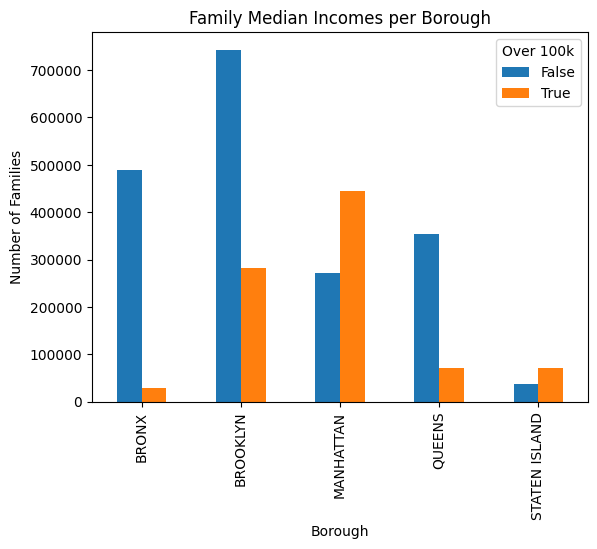

In [34]:
#creating a col so that we sort over 100k and under 100k salaries
rat_income["Over 100k"] = (rat_income["Families Median Income (Dollars)"] >= 100000) | (rat_income["Married-Couple Families Median Income (Dollars)"] >= 100000)

#Chi-Squared test
contingency = pd.crosstab(rat_income["Borough"], rat_income["Over 100k"])
contingency.plot(kind='bar', stacked=False)

#Plot
plt.xlabel("Borough")
plt.ylabel("Number of Families")
plt.title("Family Median Incomes per Borough")
plt.show()

After conducting the chi-squared test, we have a p-value of 0.0. Since this value is less than our alpha value of 0.05, we choose to reject the null hypothesis. We can use this information to determine that certain Boroughs tend to be wealthier than others. In the future, we can plan to look into whether or not wealthier boroughs have a negative correlation with rat sightings.

In [35]:
chi2_table = stats.chi2_contingency(contingency, correction=False)
chi2_table

Chi2ContingencyResult(statistic=573459.4633396, pvalue=0.0, dof=4, expected_freq=array([[351752.13836749, 166545.86163251],
       [695776.28704644, 329432.71295356],
       [486352.99222871, 230276.00777129],
       [287923.43632067, 136324.56367933],
       [ 72996.1460367 ,  34561.8539633 ]]))